In [22]:
import sys
import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn import preprocessing

from sklearn.model_selection import KFold as KF
from sklearn.metrics import mean_absolute_error as MAE
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score as R2

from sklearn.preprocessing import StandardScaler as Sscale
from sklearn.decomposition import PCA


from sklearn.linear_model import LinearRegression as LR
from sklearn.tree import DecisionTreeRegressor as DTR
from sklearn.neighbors import KNeighborsRegressor as KNN
from sklearn.ensemble import RandomForestRegressor as RFR
from sklearn.svm import SVR
from sklearn.svm import LinearSVR
from sklearn.neural_network import MLPRegressor as PR
import time

from sklearn.linear_model import SGDRegressor as SGDR

/Users/tianjianwang/anaconda2/lib/python2.7/site-packages/matplotlib/__init__.py:1401: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


In [2]:
# data loading
cleanData = pd.read_csv('cleanData.csv', encoding='Latin1')
cleanData.head(5)

,Unnamed: 0,dateCrawled,price,abtest,vehicleType,yearOfRegistration,gearbox,powerPS,model,kilometer,monthOfRegistration,fuelType,brand,notRepairedDamage,postalCode,sellSpeed
0,2,2016-03-14 12:52:21,9800,1,suv,55,1,163,grand,125.0,8,0,jeep,0,90,22 days 12:47:46.000000000
1,3,2016-03-17 16:54:04,1500,1,smallcar,52,0,75,golf,150.0,6,1,volkswagen,0,91,0 days 17:40:17.000000000
2,4,2016-03-31 17:25:20,3600,1,smallcar,59,0,69,fabia,90.0,7,0,skoda,0,60,6 days 10:17:21.000000000
3,5,2016-04-04 17:36:23,650,1,sedan,46,0,102,3er,150.0,10,1,bmw,1,33,2 days 19:17:07.000000000
4,6,2016-04-01 20:48:51,2200,1,convertible,55,0,109,2_reihe,150.0,8,1,peugeot,0,67,4 days 18:18:39.000000000


In [3]:
categoricalLabels = ['model', 'brand', 'vehicleType']
encoder = {}

encodedData = cleanData.copy()

for label in categoricalLabels:
    encoder[label] = preprocessing.LabelEncoder()
    encoder[label].fit(encodedData[label])
    tr = encoder[label].transform(encodedData[label]) 
    encodedData.loc[:, label + '_feat'] = pd.Series(tr, index=encodedData.index)
    encodedData.drop(label, axis = 1, inplace = True)

encodedData.dtypes

Unnamed: 0               int64
dateCrawled             object
price                    int64
abtest                   int64
yearOfRegistration       int64
gearbox                  int64
powerPS                  int64
kilometer              float64
monthOfRegistration      int64
fuelType                 int64
notRepairedDamage        int64
postalCode               int64
sellSpeed               object
model_feat               int64
brand_feat               int64
vehicleType_feat         int64
dtype: object

In [4]:
speedLabel = encodedData['sellSpeed']
nextData = encodedData.drop(['sellSpeed', 'dateCrawled', 'Unnamed: 0'], axis = 1)
numData = nextData.astype(float)
numData.to_csv('data.csv')

In [5]:
labels = numData['price']
labels.describe()

count    249317.000000
mean       5999.257014
std        6577.503117
min         100.000000
25%        1500.000000
50%        3699.000000
75%        7999.000000
max       74900.000000
Name: price, dtype: float64

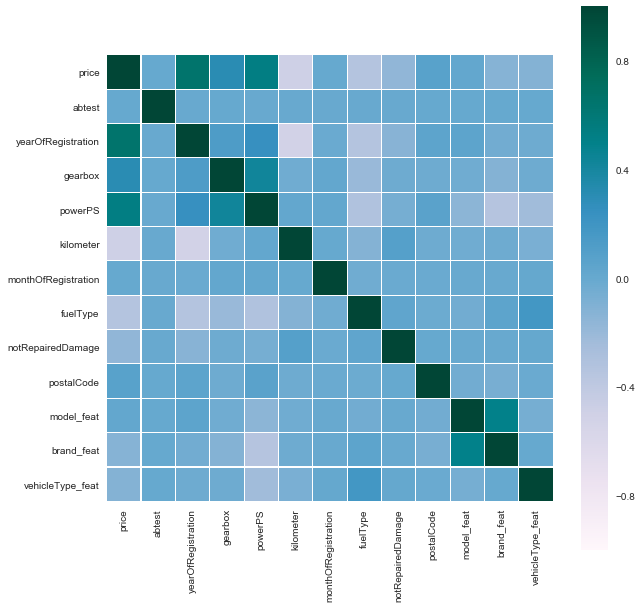

In [6]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(numData.corr(), annot = False, vmax = 1.0, square = True, linewidth = 0.1, cmap="PuBuGn", ax = ax)
sns.plt.show()

In [30]:
X = numData.drop('price', axis = 1).values
Y = labels.values

kf = KF(n_splits = 10, random_state = 42)

def CV_10_fold(clr, X, Y, islog = False):
    score = 0.0
    acc_score = 0.0
    mean_absolute_score = 0.0
    if islog:
        origY = np.exp(Y)
    i = -1
    arrow = "=========="
    for train, test in kf.split(X, Y):
        i += 1
        clr.fit(X[train], Y[train])
        pred = clr.predict(X[test])
        if islog:
            pred = np.exp(pred)
            real = origY[test]
        else:
            real = Y[test]
        score += R2(X[test],Y[test])
        acc_score += MSE(real,pred)
        mean_absolute_score += MAE(real, pred)
        arrow = arrow[:i]+">"+arrow[i+1:]
        sys.stdout.write('\r'+arrow)
    
    print "\r\n"
    return (Y.shape[0], score/10, acc_score / 10, mean_absolute_score/10)

In [8]:
sca = Sscale()
scaX = sca.fit_transform(X)


pca = PCA(n_components = 7)
pca.fit(X)
for num in pca.explained_variance_ratio_:
    print format(num, 'f')

print X.shape
pcaX = pca.transform(X)
print pcaX.shape

logY = np.log(Y)

0.535991
0.225058
0.156041
0.067421
0.011898
0.002127
0.001146
(249317, 12)
(249317, 7)


In [39]:
lr = LR()
res = CV_10_fold(clr=lr, X=X, Y=Y)

print "The whole number of examples is {}".format(res[0])
print "The score of a Linear Regressor is {}".format(res[1])
print "The mean squared error of a Linear Regressor is {}".format(res[2])
print "The mean absolute error of a Linear Regressor is {}".format(res[3])

>>>>>>>>>>

The whole number of examples is 249317
The score of a Linear Regressor is 0.660868702317
The mean squared error of a Linear Regressor is 14670896.4755
The mean absolute error of a Linear Regressor is 2567.74155929


In [40]:
lr = LR()

res = CV_10_fold(clr = lr, X=X, Y = logY, islog = True)

print "The whole number of examples is {}".format(res[0])
print "The score of a Linear Regressor is {}".format(res[1])
print "The mean squared error of a Linear Regressor is {}".format(res[2])
print "The mean absolute error of a Linear Regressor is {}".format(res[3])
print numData.dtypes
print lr.coef_
print lr.intercept_

>>>>>>>>>>

The whole number of examples is 249317
The score of a Linear Regressor is 0.756750400865
The mean squared error of a Linear Regressor is 10521464.9002
The mean absolute error of a Linear Regressor is 1781.07228354
price                  float64
abtest                 float64
yearOfRegistration     float64
gearbox                float64
powerPS                float64
kilometer              float64
monthOfRegistration    float64
fuelType               float64
notRepairedDamage      float64
postalCode             float64
model_feat             float64
brand_feat             float64
vehicleType_feat       float64
dtype: object
[  2.51513925e-03   9.93959981e-02   5.56751107e-02   9.04614422e-03
  -5.43327812e-03   4.42608296e-03  -2.21081334e-01  -6.25136385e-01
   7.22229295e-04  -2.89276903e-04   4.31164406e-03  -4.76374499e-02]
2.5260542206


In [34]:
lr = LR()
res = CV_10_fold(clr = lr, X=pcaX, Y = logY, islog = True)

print "The whole number of examples is {}".format(res[0])
print "The score of a Linear Regressor is {}".format(res[1])
print "The mean squared error of a Linear Regressor is {}".format(res[2])
print "The mean absolute error of a Linear Regressor is {}".format(res[3])

>>>>>>>>>>

The whole number of examples is 249317
The score of a Linear Regressor is 0.715581732013
The mean squared error of a Linear Regressor is 12303344.4515
The mean absolute error of a Linear Regressor is 1895.26615037


In [66]:
num_example, score, mse, mae = CV_10_fold(clr = DTR(random_state = 0), X=X, Y=Y)
print "The whole number of examples is {}".format(num_example)
print "The score of a decision tree regressor is {}".format(score)
print "The mean squared error of a decision tree regressor is {}".format(mse)
print "The mean absolute error of a decision tree regressor is {}".format(mae)

The whole number of examples is 249317
The score of a decision tree regressor is 0.847034911853
The mean squared error of a decision tree regressor is 6615971.57016
The mean absolute error of a decision tree regressor is 1262.649209


In [41]:
diff_depth = [x for x in xrange(16, 19)]
diff_split = [x for x in xrange(27, 30)]
minimum = 0
min_depth = 0
min_split = 0
for depth in diff_depth:
    for split in diff_split:
        dtr = DTR(max_depth=depth, random_state = 0, min_samples_split = split)
        temp_error = CV_10_fold(clr = dtr, X=X, Y=Y)

        if temp_error[1] > minimum:
            minimum = temp_error[1]
            min_depth = depth
            min_split = split
        print temp_error[1], depth, split
    
print min_depth, min_split

>>>>>>>>>>

0.883220868266 16 27
>>>>>>>>>>

0.883417851588 16 28
>>>>>>>>>>

0.883151837988 16 29
>>>>>>>>>>

0.883461443362 17 27
>>>>>>>>>>

0.883729636339 17 28
>>>>>>>>>>

0.883610386095 17 29
>>>>>>>>>>

0.883661175181 18 27
>>>>>>>>>>

0.883919220645 18 28
>>>>>>>>>>

0.883671124057 18 29
18 28


In [42]:
orig_dtr = DTR(max_depth=18, random_state = 0, min_samples_split = 28)
num_example, score, mse, mae = CV_10_fold(clr = orig_dtr, X= X, Y=Y)
print "The whole number of examples is {}".format(num_example)
print "The score of a decision tree regressor is {}".format(score)
print "The mean squared error of a decision tree regressor is {}".format(mse)
print "The mean absolute error of a decision tree regressor is {}".format(mae)

>>>>>>>>>>

The whole number of examples is 249317
The score of a decision tree regressor is 0.883919220645
The mean squared error of a decision tree regressor is 5022391.52348
The mean absolute error of a decision tree regressor is 1202.70431642


In [68]:
print numData.dtypes
print orig_dtr.feature_importances_

price                  float64
abtest                 float64
yearOfRegistration     float64
gearbox                float64
powerPS                float64
kilometer              float64
monthOfRegistration    float64
fuelType               float64
notRepairedDamage      float64
postalCode             float64
model_feat             float64
brand_feat             float64
vehicleType_feat       float64
dtype: object
[  1.11847595e-04   6.02744851e-01   4.61250536e-03   2.69297342e-01
   2.37548175e-02   2.72727025e-03   6.82145935e-03   5.05872386e-03
   7.34884941e-03   3.24026815e-02   2.45856342e-02   2.05340185e-02]


In [101]:
diff_depth = [x for x in xrange(16,20)]
diff_split = [x for x in xrange(46, 50)]
minimum = 0
min_depth = 0
min_split = 0
for depth in diff_depth:
    for split in diff_split:
        dtr = DTR(max_depth=depth, random_state = 0, min_samples_split = split)
        temp_error = CV_10_fold(clr=dtr, X = pcaX, Y=Y)

        if temp_error[1] > minimum:
            minimum = temp_error[1]
            min_depth = depth
            min_split = split
        print temp_error[1], depth, split
    
print min_depth, min_split

orig_dtr = DTR(max_depth=min_depth, random_state = 0, min_samples_split = min_split)
num_example, score, mse, mae = CV_10_fold(clr=orig_dtr, X=pcaX, Y=Y)
print "The whole number of examples is {}".format(num_example)
print "The score of a decision tree regressor is {}".format(score)
print "The mean squared error of a decision tree regressor is {}".format(mse)
print "The mean absolute error of a decision tree regressor is {}".format(mae)

0.834822172439 16 46
0.835196976325 16 47
0.835351538949 16 48
0.834519261058 16 49
0.834872193921 17 46
0.835070266707 17 47
0.835283000395 17 48
0.83499961956 17 49
0.83515141653 18 46
0.835279505687 18 47
0.835398854898 18 48
0.835327225004 18 49
0.835055198477 19 46
0.835313166823 19 47
0.835034511861 19 48
0.835085228162 19 49
18 48
The whole number of examples is 249317
The score of a decision tree regressor is 0.835398854898
The mean squared error of a decision tree regressor is 7121484.43781
The mean absolute error of a decision tree regressor is 1452.93120017


In [108]:
diff_depth = [x for x in xrange(15,18)]
diff_split = [x for x in xrange(60, 64)]
minimum = 0
min_depth = 0
min_split = 0
for depth in diff_depth:
    for split in diff_split:
        dtr = DTR(max_depth=depth, random_state = 0, min_samples_split = split)
        temp_error = CV_10_fold(clr=dtr, X = X, Y=logY, islog = True)

        if temp_error[1] > minimum:
            minimum = temp_error[1]
            min_depth = depth
            min_split = split
        print temp_error[1], depth, split
    
print min_depth, min_split

orig_dtr = DTR(max_depth=min_depth, random_state = 0, min_samples_split = min_split)
num_example, score, mse, mae = CV_10_fold(clr=orig_dtr, X=X, Y=logY, islog = True)
print "The whole number of examples is {}".format(num_example)
print "The score of a decision tree regressor is {}".format(score)
print "The mean squared error of a decision tree regressor is {}".format(mse)
print "The mean absolute error of a decision tree regressor is {}".format(mae)

0.858254293902 15 60
0.858270575291 15 61
0.858320700416 15 62
0.858203710187 15 63
0.85935698663 16 60
0.859206067511 16 61
0.859371199316 16 62
0.859264829467 16 63
0.859297790184 17 60
0.859239834462 17 61
0.859364409023 17 62
0.859236162777 17 63
16 62
The whole number of examples is 249317
The score of a decision tree regressor is 0.859371199316
The mean squared error of a decision tree regressor is 5621359.22482
The mean absolute error of a decision tree regressor is 1253.89939144


In [ ]:
reducedX = numData.drop(['price', 'abtest', 'postalCode', 'monthOfRegistration'], axis = 1).values

In [126]:
diff_depth = [x for x in xrange(21,28)]
diff_split = [x for x in xrange(18, 25)]
minimum = 0
min_depth = 0
min_split = 0
for depth in diff_depth:
    for split in diff_split:
        dtr = DTR(max_depth=depth, random_state = 0, min_samples_split = split)
        temp_error = CV_10_fold(clr=dtr, X = reducedX, Y=Y)

        if temp_error[1] > minimum:
            minimum = temp_error[1]
            min_depth = depth
            min_split = split
        print temp_error[1], depth, split
    
print min_depth, min_split

orig_dtr = DTR(max_depth=min_depth, random_state = 0, min_samples_split = min_split)
num_example, score, mse, mae = CV_10_fold(clr=orig_dtr, X=reducedX, Y=Y)
print "The whole number of examples is {}".format(num_example)
print "The score of a decision tree regressor is {}".format(score)
print "The mean squared error of a decision tree regressor is {}".format(mse)
print "The mean absolute error of a decision tree regressor is {}".format(mae)

0.892893160111 21 18
0.893869675636 21 19
0.893754677222 21 20
0.894024043311 21 21
0.894041284949 21 22
0.893919090504 21 23
0.893331772491 21 24
0.892951894295 22 18
0.8937345863 22 19
0.894049933105 22 20
0.893893482737 22 21
0.894359112496 22 22
0.893903402009 22 23
0.893726401538 22 24
0.892771810432 23 18
0.893716664114 23 19
0.893761415943 23 20
0.893774376308 23 21
0.894226594292 23 22
0.893636670344 23 23
0.893511925167 23 24
0.892797255789 24 18
0.893493768434 24 19
0.893797478072 24 20
0.894230878312 24 21
0.894233647999 24 22
0.893862002706 24 23
0.893681075556 24 24
0.89289065642 25 18
0.893645786318 25 19
0.89418955227 25 20
0.894184330201 25 21
0.894151919501 25 22
0.893472813405 25 23
0.893750028627 25 24
0.892729682149 26 18
0.893799984745 26 19
0.893825734848 26 20
0.894131223684 26 21
0.894270578779 26 22
0.893560811581 26 23
0.893785939419 26 24
0.892490102692 27 18
0.893774251401 27 19
0.893773530811 27 20
0.894080791296 27 21
0.893888391912 27 22
0.893755151536 27

In [32]:
diff_near = [2*x+1 for x in xrange(2,5)]
minimum = 0
min_near = 0
for near in diff_near:
    nn = KNN(n_neighbors = near, weights = 'distance')
    temp_error = CV_10_fold(clr=nn, X = X, Y=Y)

    if temp_error[1] > minimum:
        minimum = temp_error[1]
        min_near = near
    print temp_error[1], near
    
print min_near

orig_nn = KNN(n_neighbors = min_near)
num_example, score, mse, mae = CV_10_fold(clr=orig_nn, X=X, Y=Y)
print "The whole number of examples is {}".format(num_example)
print "The score of a K-Nearest-Neighbor regressor is {}".format(score)
print "The mean squared error of a K-Nearest-Neighbor regressor is {}".format(mse)
print "The mean absolute error of a K-Nearest-Neighbor regressor is {}".format(mae)

0.83356915402 5
0.833513467911 7
0.832051489381 9
5
The whole number of examples is 249317
The score of a K-Nearest-Neighbor regressor is 0.807896024066
The mean squared error of a K-Nearest-Neighbor regressor is 8312363.10497
The mean absolute error of a K-Nearest-Neighbor regressor is 1583.34378046


In [43]:
threeNn = KNN(n_neighbors=5, weights = 'distance')
res = CV_10_fold(clr = threeNn, X=X, Y = Y)

print "The whole number of examples is {}".format(res[0])
print "The score of a 3-Nearest Neighbor Regressor is {}".format(res[1])
print "The mean squared error of a 3-Nearest Neighbor Regressor is {}".format(res[2])
print "The mean absolute error of a 3-Nearest Neighbor Regressor is {}".format(res[3])

>>>>>>>>>>

The whole number of examples is 249317
The score of a 3-Nearest Neighbor Regressor is 0.83356915402
The mean squared error of a 3-Nearest Neighbor Regressor is 7202274.13043
The mean absolute error of a 3-Nearest Neighbor Regressor is 1375.66674426


In [131]:
diff_depth = [x for x in xrange(22,28)]
diff_split = [x for x in xrange(2, 9)]
minimum = 0
min_depth = 0
min_split = 0
for depth in diff_depth:
    for split in diff_split:
        rfr = RFR(max_depth=depth, min_samples_split=split, random_state=0, n_estimators = 10)
        temp_error = CV_10_fold(clr=rfr, X = X, Y=Y)

        if temp_error[1] > minimum:
            minimum = temp_error[1]
            min_depth = depth
            min_split = split
        print temp_error[1], depth, split
    
print min_depth, min_split

0.910798260701 22 2
0.911204928507 22 3
0.911445453836 22 4
0.911472204403 22 5
0.911566681952 22 6
0.911575916189 22 7
0.911600579715 22 8
0.910621597386 23 2
0.911413568792 23 3
0.91154889792 23 4
0.911480103942 23 5
0.911449801457 23 6
0.911598591121 23 7
0.911318003683 23 8
0.911076244126 24 2
0.911171528889 24 3
0.911361527217 24 4
0.911361681032 24 5
0.911682246797 24 6
0.911653937528 24 7
0.911697232226 24 8
0.910690570591 25 2
0.910738228764 25 3
0.911445707652 25 4
0.911443357285 25 5
0.911679641365 25 6
0.911759115212 25 7
0.911607986435 25 8
0.910760499963 26 2
0.911129840023 26 3
0.91122256896 26 4
0.911493856238 26 5
0.911519316593 26 6
0.91171013831 26 7
0.911619527451 26 8
0.910718809925 27 2
0.911251831839 27 3
0.911256326678 27 4
0.911440249298 27 5
0.911590135499 27 6
0.911865124332 27 7
0.911685727761 27 8
27 7


In [132]:
rfr = RFR(max_depth=27, min_samples_split=7, random_state=0, n_estimators = 100)

res = CV_10_fold(clr = rfr, X=X, Y = Y)

print "The whole number of examples is {}".format(res[0])
print "The score of a 3-Nearest Neighbor Regressor is {}".format(res[1])
print "The mean squared error of a 3-Nearest Neighbor Regressor is {}".format(res[2])
print "The mean absolute error of a 3-Nearest Neighbor Regressor is {}".format(res[3])

The whole number of examples is 249317
The score of a 3-Nearest Neighbor Regressor is 0.917760224312
The mean squared error of a 3-Nearest Neighbor Regressor is 3557359.23571
The mean absolute error of a 3-Nearest Neighbor Regressor is 1008.26873769


In [35]:
lsvr = LinearSVR(random_state = 0)
res = CV_10_fold(clr = lsvr, X=scaX, Y = logY, islog = True)

print "The whole number of examples is {}".format(res[0])
print "The score of an SVM Regressor is {}".format(res[1])
print "The mean squared error of an SVM Regressor is {}".format(res[2])
print "The mean absolute error of an SVM Regressor is {}".format(res[3])

>>>>>>>>>>

The whole number of examples is 249317
The score of an SVM Regressor is 0.764798357858
The mean squared error of an SVM Regressor is 10172601.6624
The mean absolute error of an SVM Regressor is 1728.23019248


In [36]:
svm = SVR(kernel="rbf", max_iter=500000)
res = CV_10_fold(clr = svm, X=scaX, Y=logY,islog=True)

print "The whole number of examples is {}".format(res[0])
print "The score of an SVM Regressor is {}".format(res[1])
print "The mean squared error of an SVM is {}".format(res[2])
print "The mean absolute error of an SVM Regressor is {}".format(res[3])

The whole number of examples is 249317
The score of an SVM Regressor is 0.848687670895
The mean squared error of an SVM is 5598044.31158
The mean absolute error of an SVM Regressor is 1287.9235301


In [18]:
print "started training!"
svm = SVR(kernel="poly", max_iter = 1000000)

res = CV_10_fold(clr = svm, X=scaX, Y = logY, islog = True)

print "The whole number of examples is {}".format(res[0])
print "The score of an SVM Regressor is {}".format(res[1])
print "The mean squared error of an SVM is {}".format(res[2])
print "The mean absolute error of an SVM Regressor is {}".format(res[3])

started training!


/Users/tianjianwang/anaconda2/lib/python2.7/site-packages/sklearn/svm/base.py:220: ConvergenceWarning: Solver terminated early (max_iter=1000000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


The whole number of examples is 249317
The score of an SVM Regressor is 0.817460874623
The mean squared error of an SVM is 8845903.20738
The mean absolute error of an SVM Regressor is 1527.81984839


In [46]:
pr = PR(hidden_layer_sizes = (1000,1000), activation = 'logistic', alpha = 0.01, batch_size = 1000, random_state = 0, early_stopping = True, max_iter = 200)

from sklearn.model_selection import train_test_split as tts
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.15, random_state = 42)
pr.fit(X_train, Y_train)
print pr.score(X_test, Y_test)

0.806405483455


In [54]:
start_time = time.time()
pr = PR(hidden_layer_sizes = (100,100), activation = 'tanh', alpha = 0.01, batch_size = 1000, random_state = 0, early_stopping = True, max_iter = 200, learning_rate_init = 0.01)

from sklearn.model_selection import train_test_split as tts
X_train, X_test, Y_train, Y_test = tts(scaX, logY, test_size = 0.4, random_state = 42)
pr.fit(X_train, Y_train)
print "start perdicting after {} seconds".format(time.time() - start_time)
start_time = time.time()
print R2(np.exp(pr.predict(X_test)), np.exp(Y_test))
print "finish predicting after {} seconds".format(time.time() - start_time)

start perdicting after 51.7032878399 seconds
0.786255561983
finish predicting after 0.655018806458 seconds


In [73]:
pr = PR(hidden_layer_sizes = (200,200), activation = 'tanh', alpha = 0.01, batch_size = 1000, random_state = 0, early_stopping = True, max_iter = 50, learning_rate_init = 0.01)

res = CV_10_fold(clr = pr, X=scaX, Y = logY, islog = True)

print "The whole number of examples is {}".format(res[0])
print "The score of a neural network regressor is {}".format(res[1])
print "The mean squared error of a neural network regressor is {}".format(res[2])
print "The mean absolute error of a neural network regressor is {}".format(res[3])

>>>>>>>>>>

The whole number of examples is 249317
The score of a neural network regressor is 0.856573518169
The mean squared error of a neural network regressor is 6205846.53844
The mean absolute error of a neural network regressor is 1326.67005934


In [81]:
import time
start_time = time.time()
X_train, X_test, Y_train, Y_test = tts(X, Y, test_size = 0.4, random_state = 10)
logY_train, logY_test = np.log(Y_train), np.log(Y_test)
sca = Sscale()
scaX_train, scaX_test = sca.fit_transform(X_train), sca.fit_transform(X_test)

In [64]:
lr = LR()
lr.fit(X_train, logY_train)
lrpred = lr.predict(X_test)
lrdata = np.exp(lrpred)
print "LR score: {}".format(R2(lrdata, Y_test))
print("LR trained %s seconds" % (time.time() - start_time))
start_time = time.time()

dtr = DTR(max_depth=18, random_state = 0, min_samples_split = 28)
dtr.fit(X_train, Y_train)
dtrdata = dtr.predict(X_test)
print "DTR score: {}".format(R2(dtrdata, Y_test))
print("DTR trained %s seconds" % (time.time() - start_time))
start_time = time.time()

kNn = KNN(n_neighbors=5, weights = 'distance')
kNn.fit(X_train, Y_train)
kNNdata = kNn.predict(X_test)
print "KNN score: {}".format(R2(kNNdata, Y_test))
print("KNN trained %s seconds" % (time.time() - start_time))
start_time = time.time()

rfr = RFR(max_depth=27, min_samples_split=7, random_state=0, n_estimators = 100)
rfr.fit(X_train, Y_train)
rfrdata = rfr.predict(X_test)
print "RFR score: {}".format(R2(rfrdata, Y_test))
print("RFR trained %s seconds" % (time.time() - start_time))

LR score: 0.731635690783
LR trained 0.344702005386 seconds
DTR score: 0.863908050658
DTR trained 0.822289943695 seconds
KNN score: 0.782747210155
KNN trained 9.94533514977 seconds
RFR score: 0.899617117881
RFR trained 69.5172979832 seconds


In [70]:
start_time = time.time()
svm = SVR(kernel="rbf", max_iter=500000)
svm.fit(scaX_train, logY_train)
svmpred = svm.predict(scaX_test)
svmdata = np.exp(svmpred)
print "SVM score: {}".format(R2(svmdata, Y_test))
print("SVM trained %s seconds" % (time.time() - start_time))

SVM score: 0.843605459733
SVM trained 8785.62111521 seconds


In [82]:
start_time = time.time()

pr = PR(hidden_layer_sizes = (200,200), activation = 'tanh', alpha = 0.01, batch_size = 1000, random_state = 0, early_stopping = True, max_iter = 50, learning_rate_init = 0.01)

pr.fit(scaX_train, logY_train)
prpred = pr.predict(scaX_test)
prdata = np.exp(prpred)
print "Neural Network score: {}".format(R2(prdata, Y_test))
print("NN trained %s seconds" % (time.time() - start_time))

Neural Network score: 0.817066992151
NN trained 67.1343359947 seconds


In [83]:
All_train = np.transpose(np.asarray((lrdata, dtrdata, kNNdata, rfrdata, svmdata, prdata)))

df = pd.DataFrame(data = All_train, columns = ["LR", "DTR","KNN", "RFR", "SVM", "PR"])
df.insert(loc=0,column="price", value = Y_test)
df.describe()

,price,LR,DTR,KNN,RFR,SVM,PR
count,99727.000000,99727.000000,99727.000000,99727.000000,99727.000000,99727.000000,99727.000000
mean,5997.077261,5558.424073,6019.453720,5998.253324,6037.402844,5813.803671,5697.418865
std,6573.843816,6305.452691,6364.381518,6109.980762,6270.905524,6103.687423,5870.396534
min,100.000000,127.094595,150.000000,100.000000,208.489854,205.906027,214.535388
25%,1500.000000,1639.718500,1650.230769,1742.057533,1688.020903,1603.862103,1558.886649
50%,3699.000000,3437.181807,3739.857143,3827.157150,3810.449641,3593.357748,3535.755349
75%,7999.000000,6914.318073,8080.153846,8091.238671,8165.861576,7809.670171,7735.859257
max,74900.000000,93520.163592,59799.000000,64872.485545,63664.120357,76989.080369,66946.950875


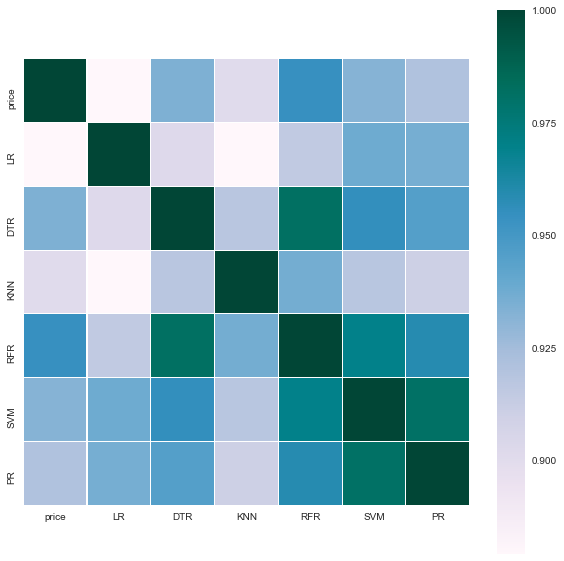

In [85]:
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(df.corr(), annot = False, vmax = 1.0, square = True, linewidth = 0.1, cmap="PuBuGn", ax = ax)
sns.plt.show()

In [89]:
l = [rfrdata, Y_test]
l = map(list, zip(*l))
res = pd.DataFrame(data=l, columns = ["Predict", "Real"])

In [111]:
res["ratio"] = (-1 * res["Predict"] / res["Real"]) + 1
res["ratio"].describe()

count    99727.000000
mean        -0.215366
std          1.805966
min       -141.811130
25%         -0.243180
50%         -0.025344
75%          0.117213
max          0.975805
Name: ratio, dtype: float64

In [115]:
print res.loc[39764]
print X_test[39764]
print encoder["model"].inverse_transform(222)
print encoder["brand"].inverse_transform(37)
print encoder["vehicleType"].inverse_transform(0)

Predict    31418.448648
Real         220.000000
ratio       -141.811130
Name: 39764, dtype: float64
[   0.   64.    0.  143.   30.   11.    0.    0.   95.  222.   37.    0.]
transporter
volkswagen
bus


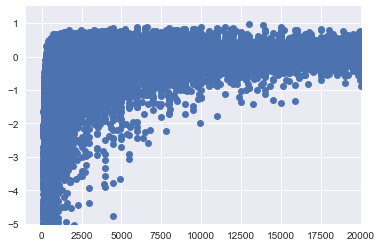

In [109]:
plt.plot(res["Real"], res["ratio"], 'o')
plt.xlim(-1000,20000)
plt.ylim(-5,1.5)
plt.show()